In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import arviz as az
from emcee import EnsembleSampler
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx
import scipy.linalg as sl
import scipy.stats as ss
import starry
from starry import Map, System, Primary, Secondary
import starry_process
from starry_process import StarryProcess
import theano
theano.config.gcc__cxxflags += " -fexceptions"
theano.config.on_opt_error = "raise"
theano.tensor.opt.constant_folding
theano.graph.opt.EquilibriumOptimizer
import theano.tensor as tt
from theano.tensor.random.utils import RandomStream
from tqdm.notebook import tqdm
from corner import corner


from StarryStarryProcess import *
from DistributionFunctions import *

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/opt/anaconda3/envs/starry-test/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/sabina/.lightkurve/cache. Please move all the files in the legacy directory /Users/sabina/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


Formulas:
$$
N\left( f \mid M y, C \right) N\left( y \mid \mu, \Lambda \right) = N\left( y \mid a, A \right) N\left( f \mid b, B \right)
$$
where
$$
A^{-1} = \Lambda^{-1} + M^T C^{-1} M
$$
$$
a = A \left( \Lambda^{-1} \mu + M^T C^{-1} M f \right)
$$
$$
b = M \mu
$$
$$
B = C + M \Lambda M^T
$$

Useful re-writing:
$$
A = \left( I + \Lambda M^T C^{-1} M \right)^{-1} \Lambda
$$

$$
B^{-1} = C^{-1} - C^{-1} M \left( I + \Lambda M^T C^{-1} M \right)^{-1} \Lambda M^T C^{-1}
$$

In [52]:
starry.config.lazy = True

ydeg = 15
udeg = 2

u1 = 0.4
u2 = 0.26

r = 20.0
dr = 5.0
n = 1
c = 0.5
mu = 30.0
sigma = 5.0
tau = 25.0

nt = 100

rng = np.random.default_rng(302592346730275158208684369480422136411)

pri = Primary(starry.Map(ydeg, udeg=udeg),
              r=0.683, m=0.81, prot=30.0, t0=0.0)
sec = Secondary(starry.Map(0, 0), 
                t0=0, r=0.2, m=0.1, prot=1.0,
                porb=4.887802443, ecc=0.0, Omega=30.0)
pri.map[1] = u1
pri.map[2] = u2


t = np.linspace(0,100*sec.porb.eval(), nt)

sys = System(pri, sec)

sp = StarryProcess(n=n, mu=mu, sigma=sigma, r=r, dr=dr, ydeg=ydeg, udeg=udeg, tau=tau, marginalize_over_inclination=False, seed=rng.integers(0, 1<<32))

ssp = StarryStarryProcess(sys, sp, nt, len(pri.map.y.eval()))

y_true = sp.sample_ylm(t).eval().reshape(nt, 256)
y_true[:,0] = 1.0

flux_true = sys.design_matrix(t).eval()[:, :-1] @ y_true.T

sigma_flux = 0.005*np.ones_like(flux_true)

flux_obs = flux_true + sigma_flux*rng.normal(size=nt)

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.


In [53]:
flux_obs.shape

(100, 100)

<ErrorbarContainer object of 3 artists>

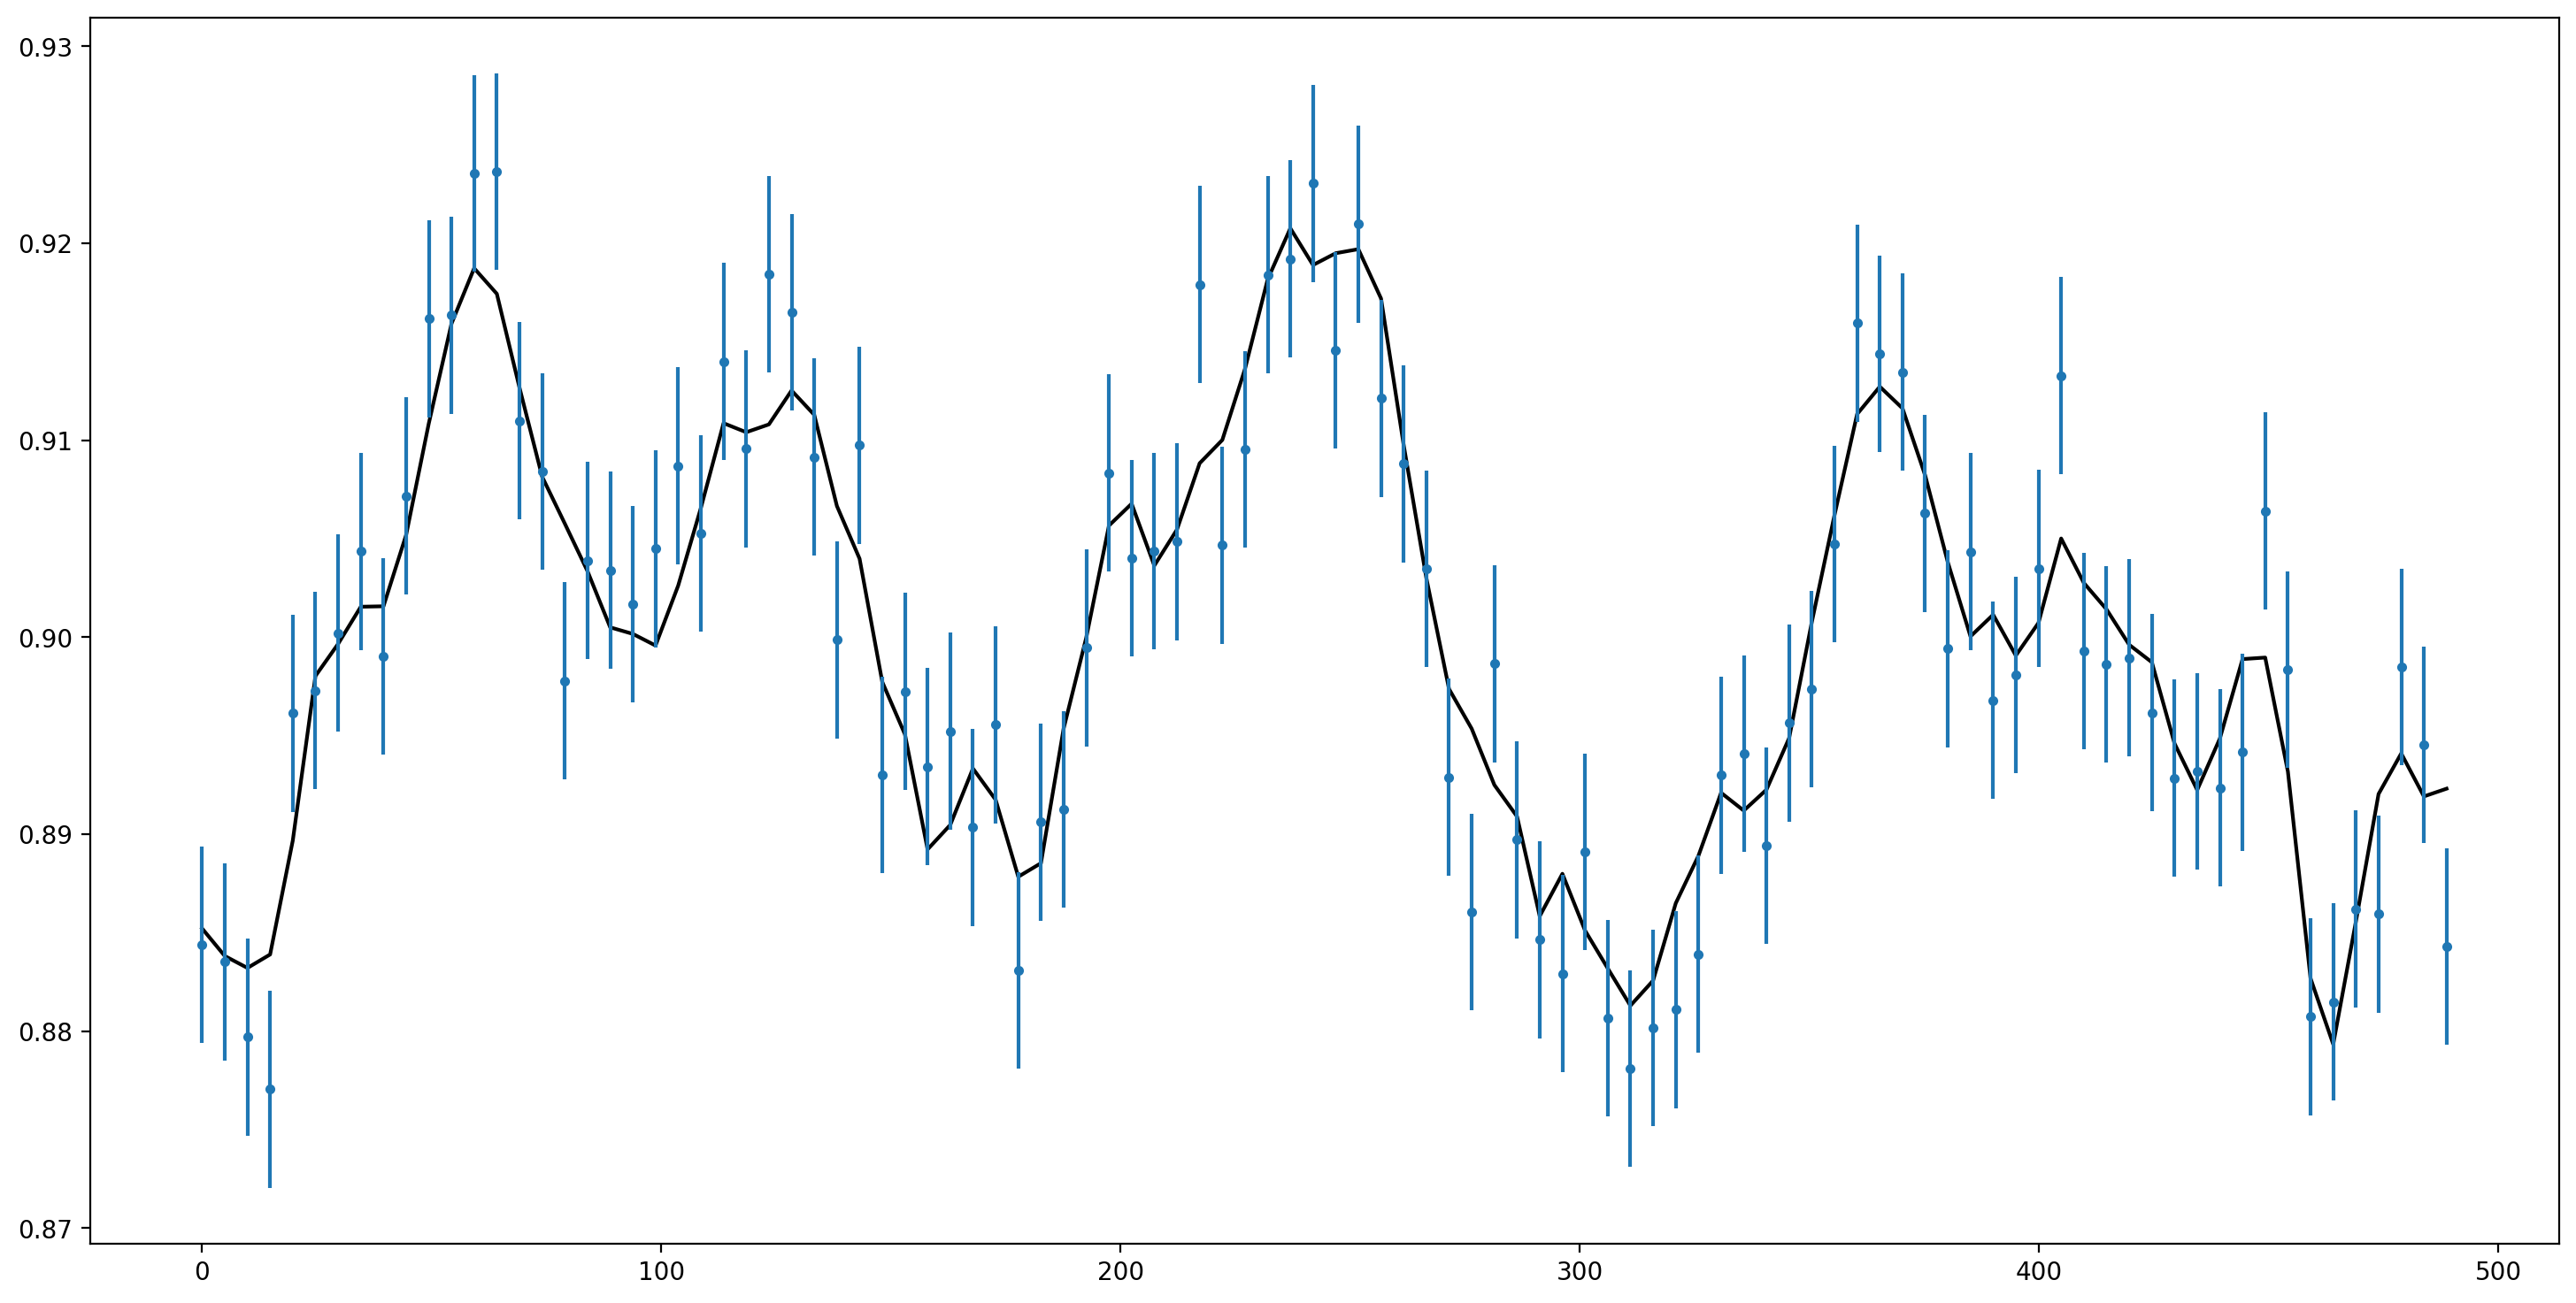

In [54]:
plt.figure(figsize=(18,9))
plt.plot(t, flux_true[0], color='k')
plt.errorbar(t, flux_obs[0], yerr=sigma_flux[0], fmt='.')

In [83]:
flux_obs1 = flux_obs[0]
t1 = t.copy()
sigma_flux1 = sigma_flux[0]
y1 = ssp.sample_ylm_conditional(t1, flux_obs1, sigma_flux1).eval()[0,:]
A_starry1 = flux_obs1.reshape(-1,1) @ np.linalg.pinv(y1.reshape(-1,1))

Pre-computing some matrices... Done.


Compiling `render`... Done.


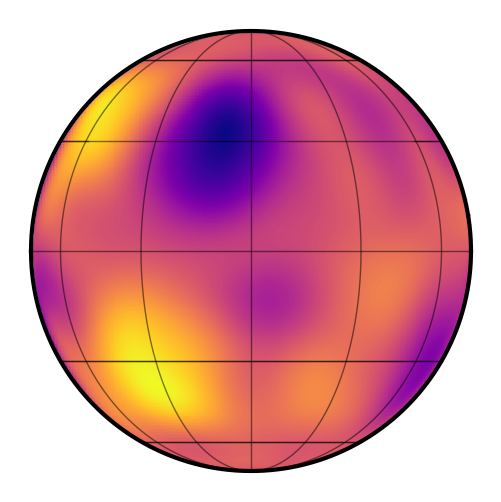

In [57]:
map = starry.Map(15,2)
map[:,:] = y1.reshape(-1)
map.show()

In [59]:
starry.config.lazy = True

ydeg = 15
udeg = 2

u1 = 0.4
u2 = 0.26

r = 10.0
dr = 5.0
n = 10
c = 0.5
mu = 30.0
sigma = 5.0
tau = 25.0

nt = 100

rng = np.random.default_rng(302592346730275158208684369480422136411)

pri = Primary(starry.Map(ydeg, udeg=udeg),
              r=0.683, m=0.81, prot=30.0, t0=0.0)
sec = Secondary(starry.Map(0, 0), 
                t0=0, r=0.2, m=0.1, prot=1.0,
                porb=4.887802443, ecc=0.0, Omega=30.0)
pri.map[1] = u1
pri.map[2] = u2


t = np.linspace(100*sec.porb.eval(), 100*sec.porb.eval()*2, nt)

sys = System(pri, sec)

sp = StarryProcess(n=n, mu=mu, sigma=sigma, r=r, dr=dr, ydeg=ydeg, udeg=udeg, tau=tau, marginalize_over_inclination=False, seed=rng.integers(0, 1<<32))

ssp = StarryStarryProcess(sys, sp, nt, len(pri.map.y.eval()))

y_true = sp.sample_ylm(t).eval().reshape(nt, 256)
y_true[:,0] = 1.0

flux_true = sys.design_matrix(t).eval()[:, :-1] @ y_true.T

sigma_flux = 0.005*np.ones_like(flux_true)

flux_obs = flux_true + sigma_flux*rng.normal(size=nt)

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.


<ErrorbarContainer object of 3 artists>

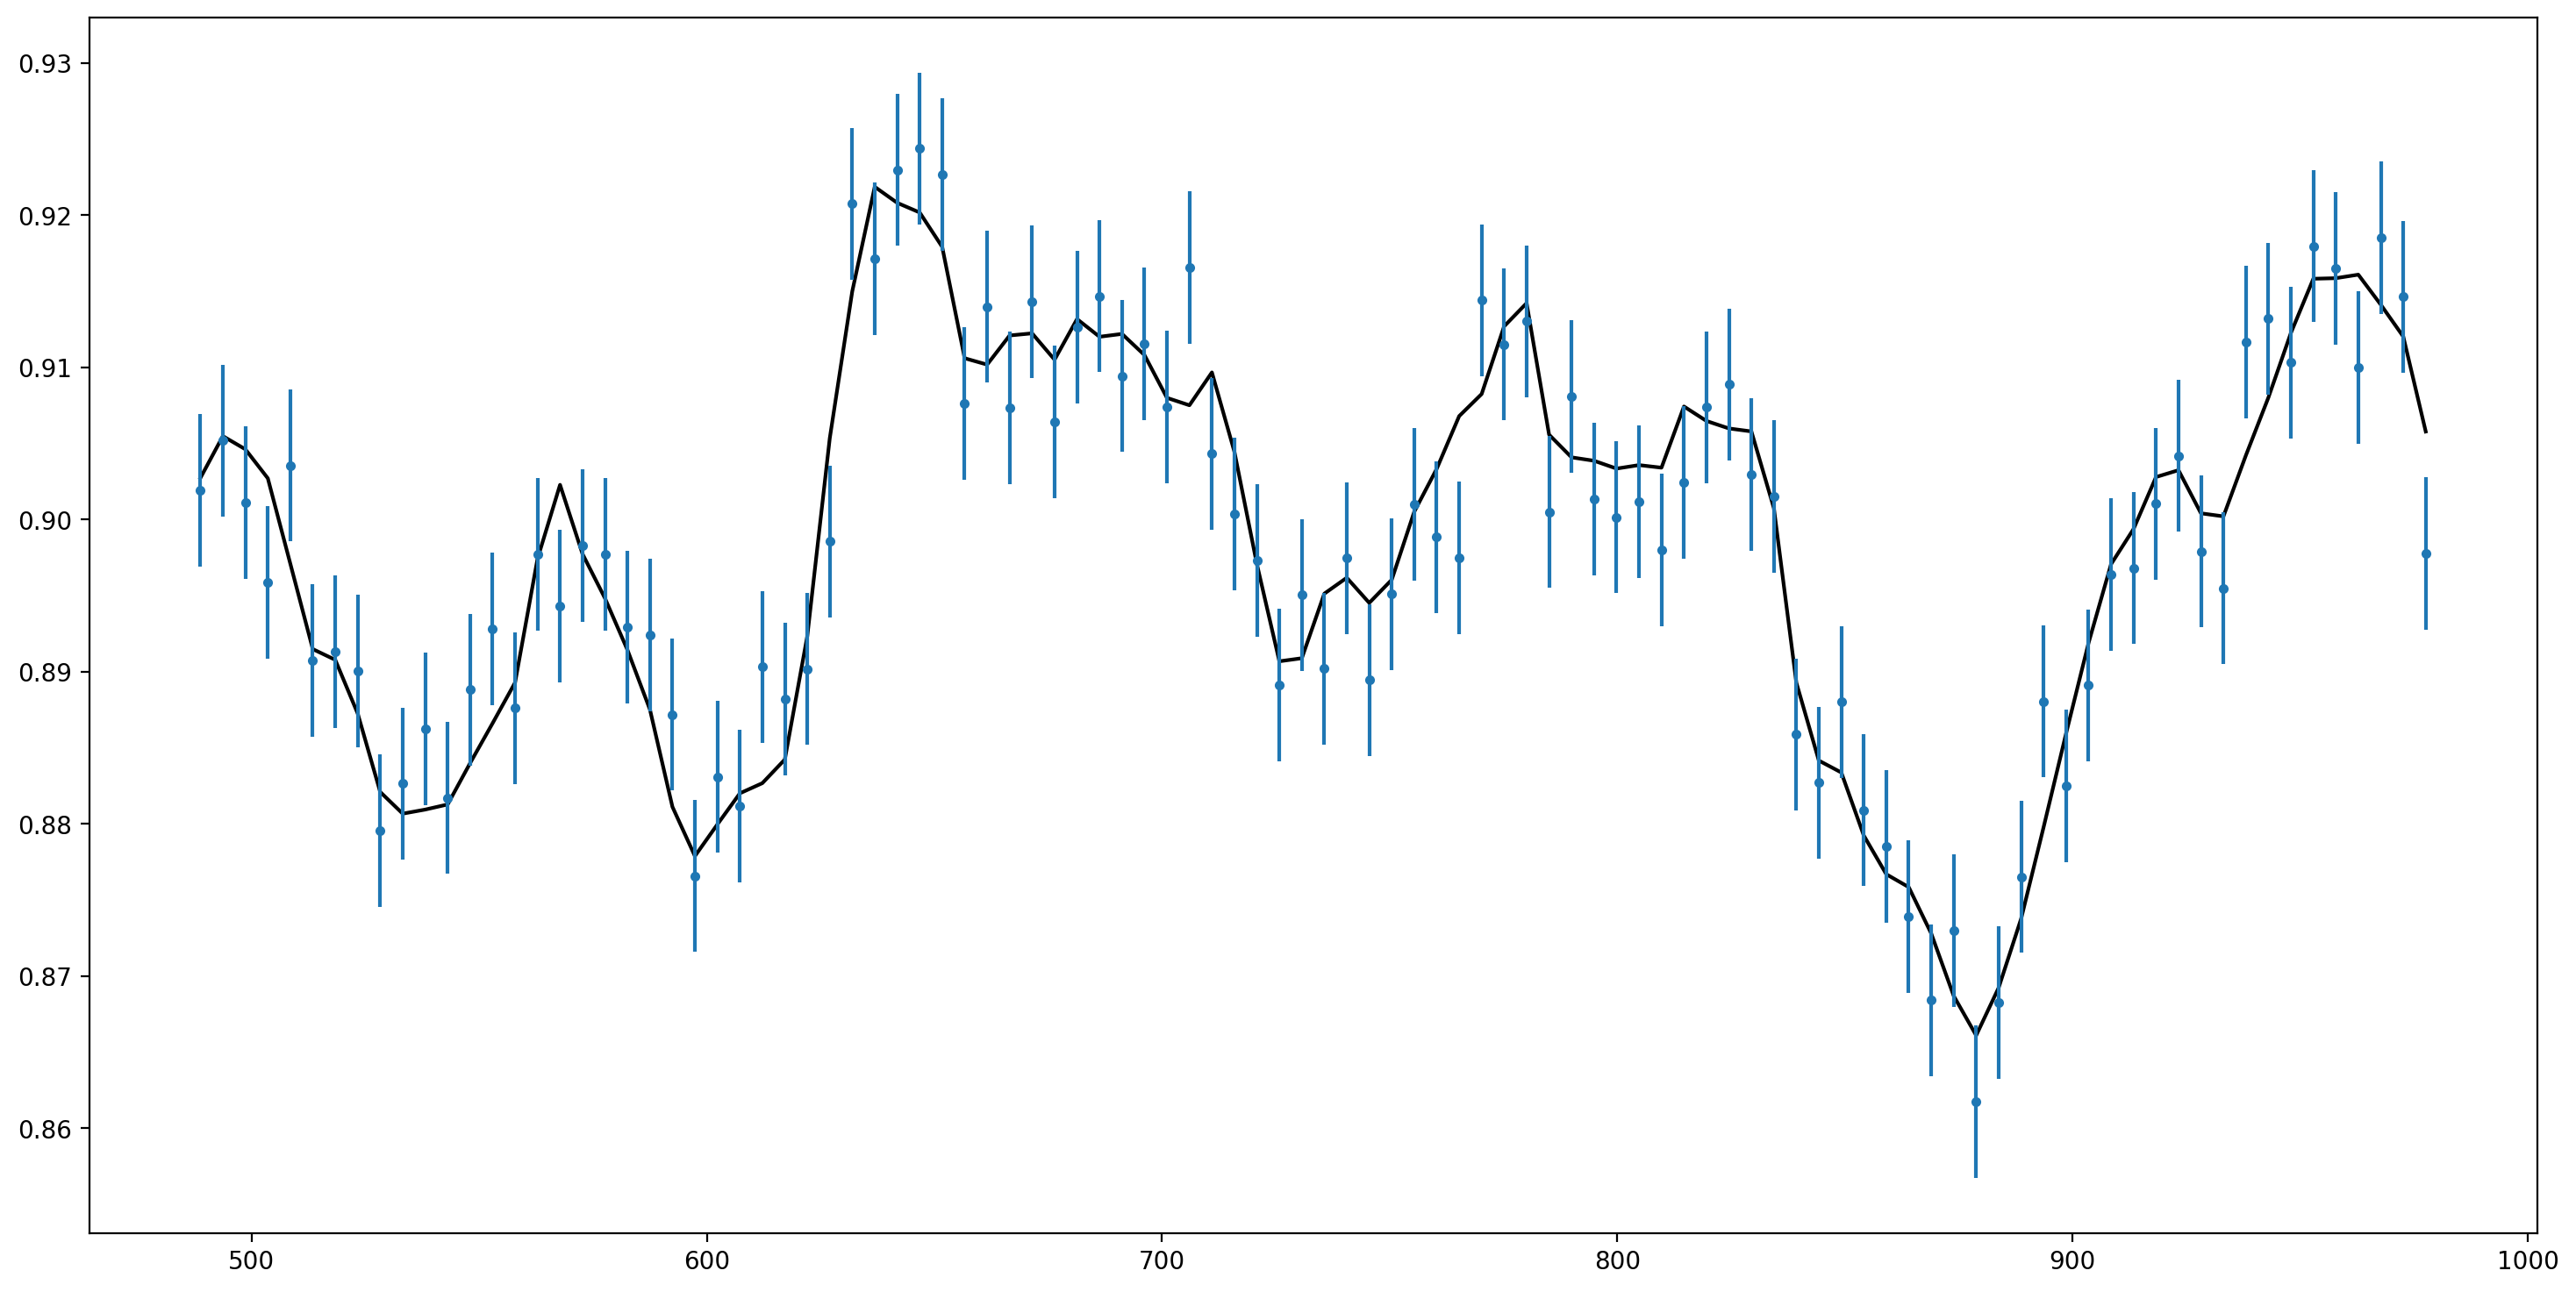

In [61]:
plt.figure(figsize=(18,9))
plt.plot(t, flux_true[0], color='k')
plt.errorbar(t, flux_obs[0], yerr=sigma_flux[0], fmt='.')

In [62]:
flux_obs2 = flux_obs[0]
t2 = t.copy()
sigma_flux2 = sigma_flux[0]
y2 = ssp.sample_ylm_conditional(t2, flux_obs2, sigma_flux2).eval()[0,:]

Pre-computing some matrices... Done.


Compiling `render`... Done.


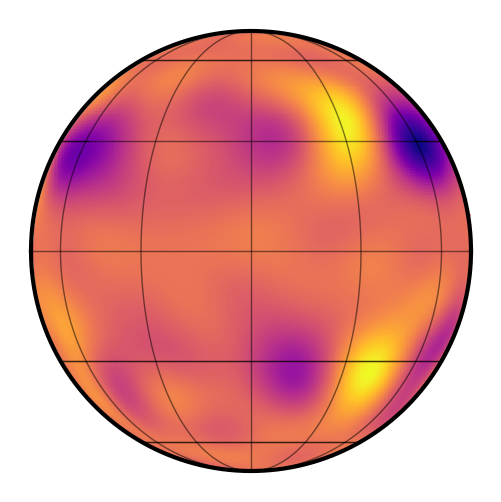

In [63]:
map = starry.Map(15,2)
map[:,:] = y2.reshape(-1)
map.show()

In [4]:
def linear_interpolate(ylm1, ylm2, times, t_k):

    t_low = times[0]
    t_high = times[-1]

    alpha = (t_k - t_low) / (t_high - t_low)
    beta = 1 - alpha

    interpolated_y = alpha * ylm1 + beta * ylm2

    return [alpha, beta], interpolated_y


In [65]:
interpolated_ys = []
interpolation_coefficients = []
for t_ in np.linspace(t1[0], t2[0], nt):
    interpolation_coeff, interpolated_y = linear_interpolate(y1, y2, np.linspace(t1[0], t2[0], nt), t_)
    interpolation_coefficients.append(interpolation_coeff)
    interpolated_ys.append(interpolated_y)

interpolation_coefficients = np.array(interpolation_coefficients)
interpolated_ys = np.array(interpolated_ys)

In [23]:
interpolated_ys[0].shape

(256,)

In [41]:
for i in range(nt):
    map = starry.Map(15,2)
    map[:,:] = interpolated_ys[i].reshape(-1)
    if i<10:
        filename = 'map-evol0' + str(i)
    else:
        filename = 'map-evol' + str(i)
    map.show(file=filename, projection='moll')

Pre-computing some matrices... 

Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.


IndexError: index 10 is out of bounds for axis 0 with size 10

In [48]:
#!/usr/bin/env python3
import gc
import logging
import subprocess
import sys
import tempfile
from pathlib import Path

import numpy as np

def make_animation(frame_rate: float) -> None:
    print("Rendering animation...")
    subprocess.run(
        [
            "/Users/sabina/Downloads/ffmpeg",
            "-y",
            "-r",
            str(frame_rate),
            "-pattern_type",
            "glob",
            "-i",
            "*.png",
            *"-c:v libx264 -pix_fmt yuv420p -vf".split(),
            "fps=30, pad=ceil(iw/2)*2:ceil(ih/2)*2",
            "out.mp4",
        ],
        check=True,
    )


# for path in sorted(Path("castro_outputs").glob("v_*_drho_*")):
make_animation(frame_rate=16)

Rendering animation...


ffmpeg version N-106378-gfa989df1c6-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static

In [87]:
BigA = np.vstack([A_starry1.T * interpolation_coefficients[:,0], A_starry1.T * interpolation_coefficients[:,1]]).T

In [88]:
f = BigA @ np.concatenate([y1, y2])

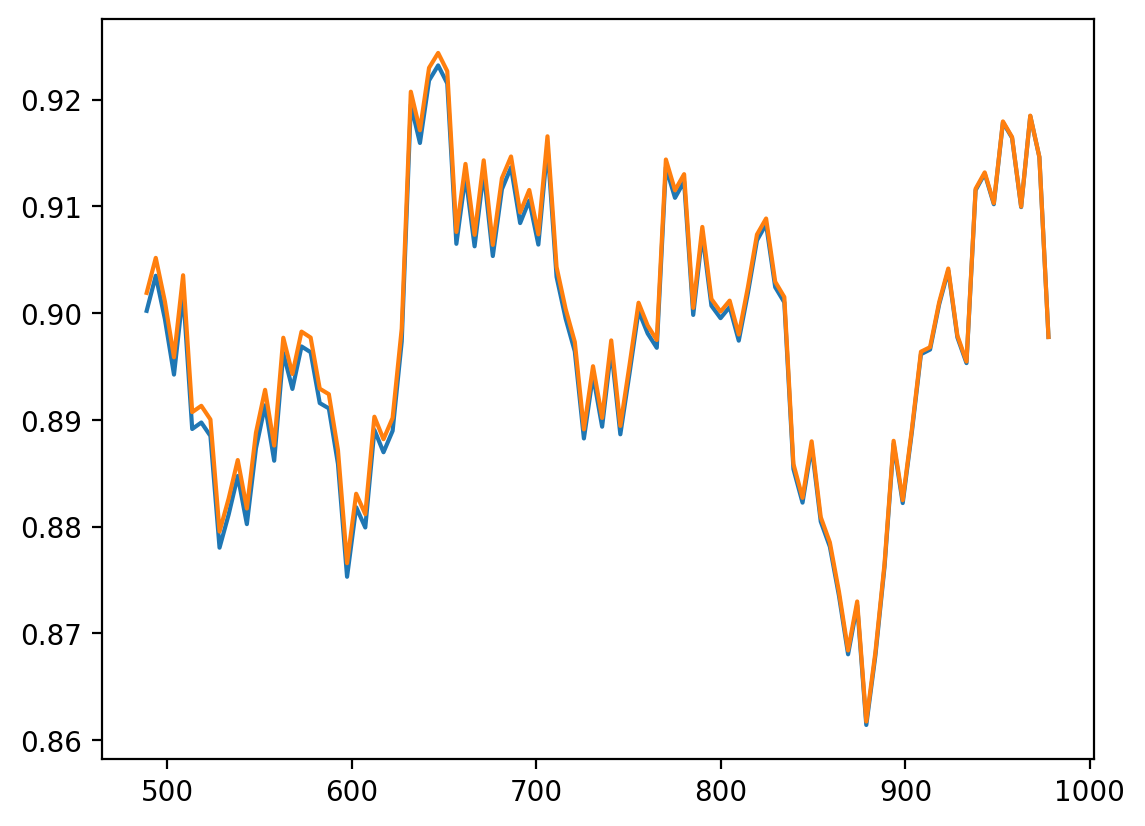

In [90]:
plt.plot(t1, f, color = 'C0')
plt.plot(t1, flux_obs1, color = 'C1')

In [5]:
starry.config.lazy = True

ydeg = 15
udeg = 2

u1 = 0.4
u2 = 0.26

r = 20.0
dr = 5.0
n = 1
c = 0.5
mu = 30.0
sigma = 5.0
tau = 100.0

nt = 100

rng = np.random.default_rng(302592346730275158208684369480422136411)

pri = Primary(starry.Map(ydeg, udeg=udeg),
              r=0.683, m=0.81, prot=100.0, t0=0.0)
sec = Secondary(starry.Map(0, 0), 
                t0=0, r=0.2, m=0.1, prot=1.0,
                porb=4.887802443, ecc=0.0, Omega=30.0)
pri.map[1] = u1
pri.map[2] = u2


t = np.linspace(0,100*sec.porb.eval(), nt)

sys = System(pri, sec)

sp = StarryProcess(n=n, mu=mu, sigma=sigma, r=r, dr=dr, ydeg=ydeg, udeg=udeg, tau=tau, marginalize_over_inclination=False, seed=rng.integers(0, 1<<32))

ssp = StarryStarryProcess(sys, sp, nt, len(pri.map.y.eval()))

y_true = sp.sample_ylm(t).eval().reshape(nt, 256)
y_true[:,0] = 1.0

flux_true = sys.design_matrix(t).eval()[:, :-1] @ y_true.T

sigma_flux = 0.005*np.ones_like(flux_true)

flux_obs = flux_true + sigma_flux*rng.normal(size=nt)

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.


<ErrorbarContainer object of 3 artists>

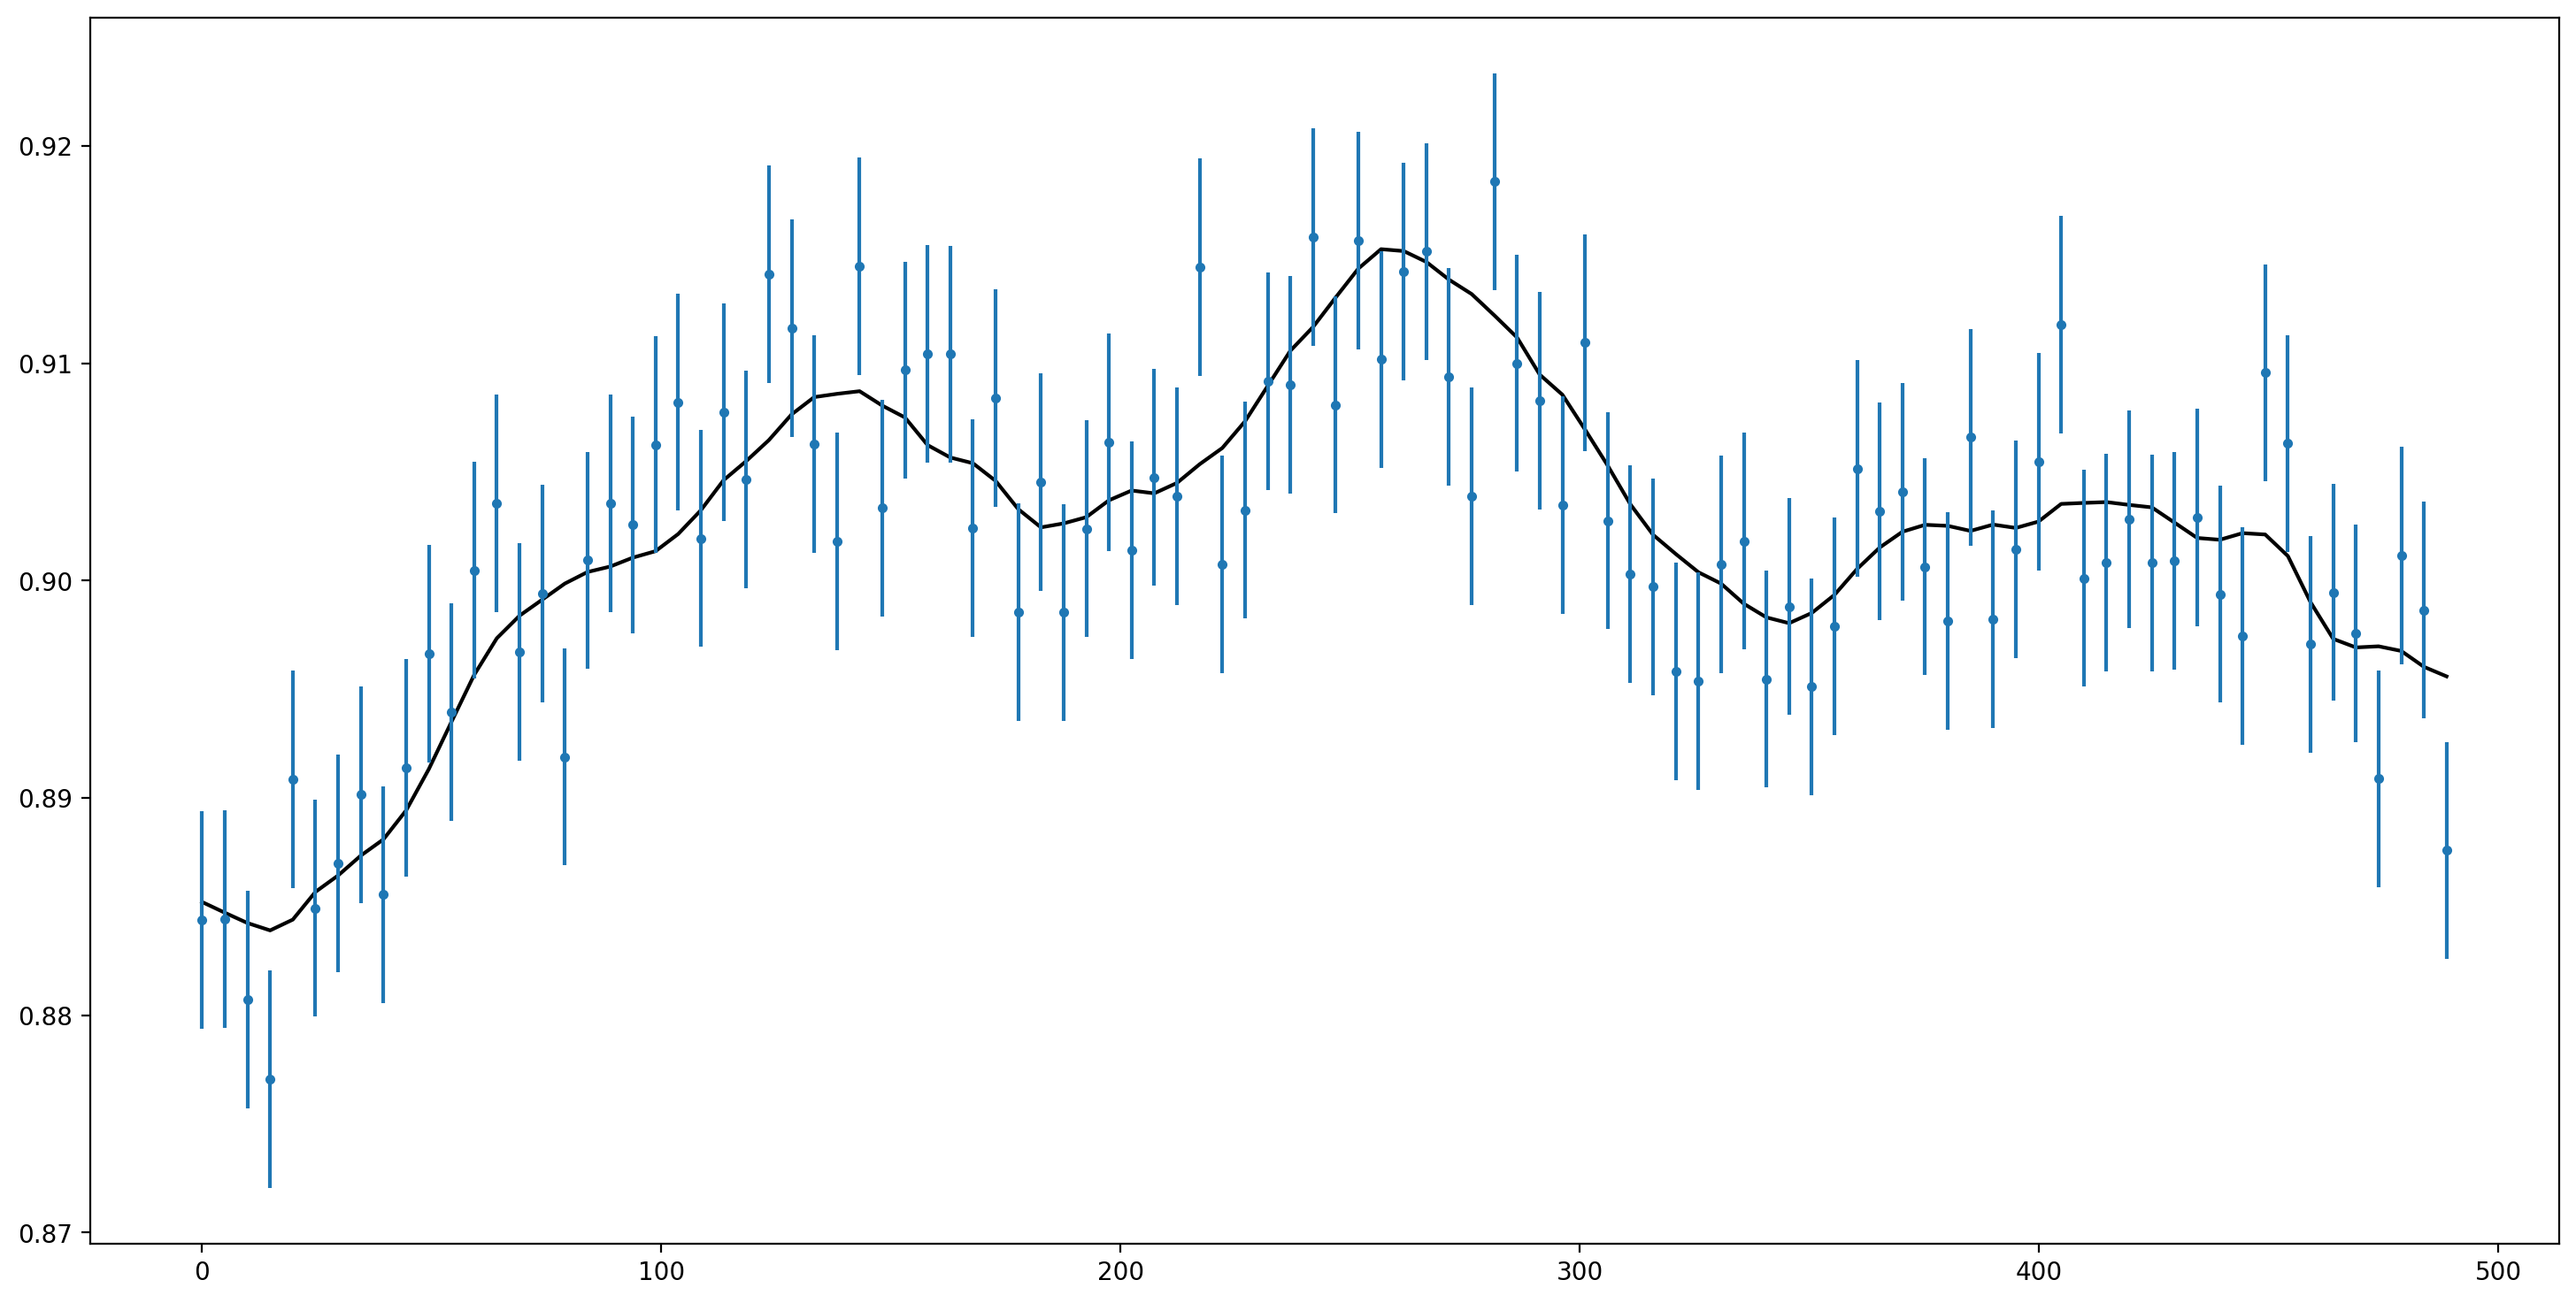

In [6]:
plt.figure(figsize=(18,9))
plt.plot(t, flux_true[0], color='k')
plt.errorbar(t, flux_obs[0], yerr=sigma_flux[0], fmt='.')

In [7]:
flux_obs = flux_obs[0]
sigma_flux = sigma_flux[0]

In [30]:
t.shape

(100,)

In [31]:
chunks = []
# Split the times and fluxes into chunks
for start_time in range(int(t[0]), int(t[-1]), 50):
    end_time = start_time + 50
    mask = (t >= start_time) & (t < end_time)
    chunk_times = t[mask]
    chunk_fluxes = flux_obs[mask]
    chunk_sigma_fluxes = sigma_flux[mask]
    chunks.append([chunk_times, chunk_fluxes, chunk_sigma_fluxes])

In [32]:
chunks = np.array(chunks)

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_89078/2930193521.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  chunks = np.array(chunks)


In [33]:
chunks.shape

(10, 3)

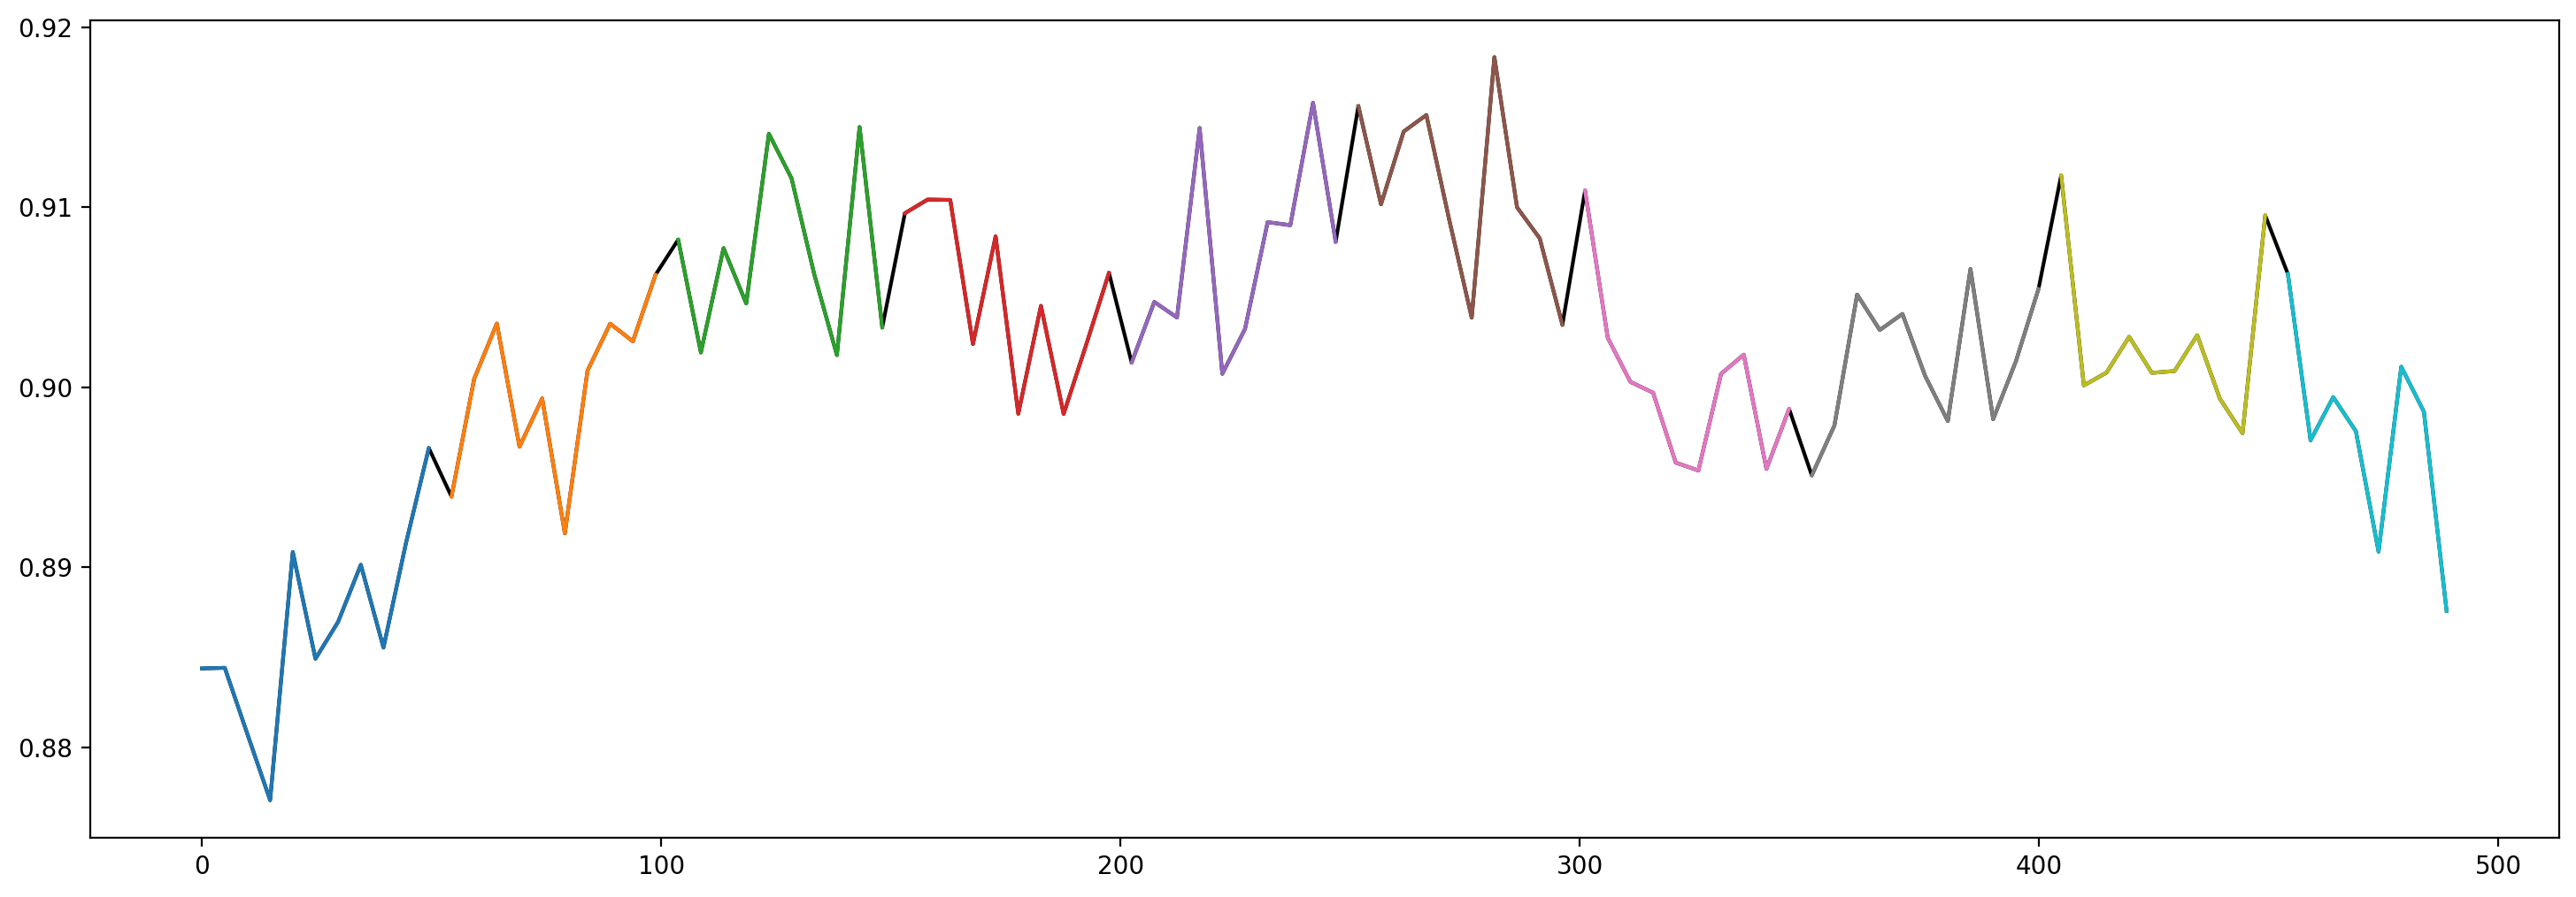

In [34]:
plt.figure(figsize=(18, 6))
plt.plot(t, flux_obs, "k-", ms=2)
for n, i in enumerate(chunks):
    plt.plot(i[0], i[1], color='C'+str(n), ms=2)

In [35]:
ylms = []
for n, chunk in enumerate(chunks):
    ylm_draw = ssp.sample_ylm_conditional(chunk[0], chunk[1], chunk[2]).eval()[0,:]
    ylms.append(ylm_draw)
ylms = np.array(ylms)

Pre-computing some matrices... Done.
Compiling `render`... Done.


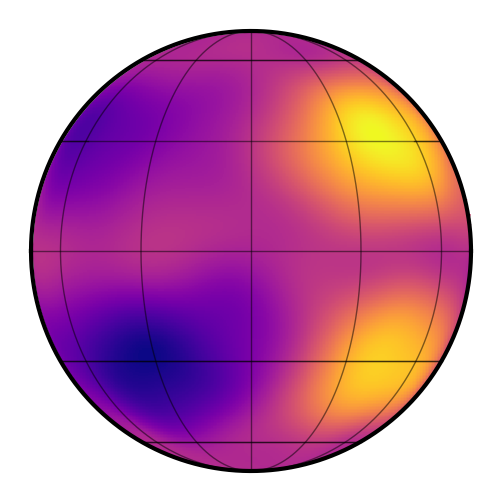

In [36]:
map = starry.Map(15,2)
map[:,:] = ylms[0].reshape(-1)
map.show()

Pre-computing some matrices... Done.
Compiling `render`... Done.


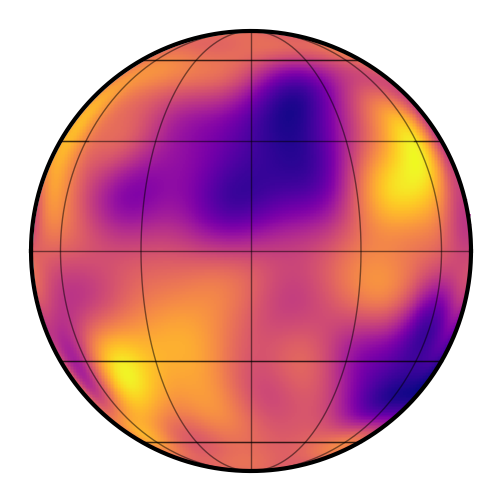

In [37]:
map = starry.Map(15,2)
map[:,:] = ylms[1].reshape(-1)
map.show()

In [39]:
interpolated_ys = []
interpolation_coefficients = []
for t_ in np.linspace(chunks[0][0][0], chunks[1][0][0], 10):
    interpolation_coeff, interpolated_y = linear_interpolate(ylms[0], ylms[1], np.linspace(chunks[0][0][0], chunks[1][0][0], 10), t_)
    interpolation_coefficients.append(interpolation_coeff)
    interpolated_ys.append(interpolated_y)

interpolation_coefficients = np.array(interpolation_coefficients)
interpolated_ys = np.array(interpolated_ys)

In [47]:
interpolated_ys = []
interpolation_coefficients = []
for n in range(9):
    for t_ in np.linspace(chunks[n][0][0], chunks[n+1][0][0], 10):
        interpolation_coeff, interpolated_y = linear_interpolate(ylms[n], ylms[n+1], np.linspace(chunks[n][0][0], chunks[n+1][0][0], 10), t_)
        interpolation_coefficients.append(interpolation_coeff)
        interpolated_ys.append(interpolated_y)
    # interpolated_chunks_ylms.append(interpolated_ys)
    # interpolation_coeff_chunks.append(interpolation_coefficients)

IndexError: index 10 is out of bounds for axis 0 with size 10

In [44]:
interpolated_ys = np.array(interpolated_ys)

In [45]:
interpolated_ys.shape

(90, 256)

In [46]:
for i in range(nt):
    map = starry.Map(15,2)
    map[:,:] = interpolated_ys[i].reshape(-1)
    if i<10:
        filename = 'map-evol0' + str(i)
    else:
        filename = 'map-evol' + str(i)
    map.show(file=filename, projection='moll')

Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matrices... Done.
Compiling `render`... Done.
Pre-computing some matric

IndexError: index 90 is out of bounds for axis 0 with size 90

In [49]:
interpolation_coefficients = np.array(interpolation_coefficients)

In [50]:
len(interpolation_coefficients)

90

In [51]:
interpolation_coefficients.shape

(90, 2)

In [52]:
A_starry1 = chunks[0][1].reshape(-1,1) @ np.linalg.pinv(ylms[0].reshape(-1,1))

In [54]:
A_starry1.shape

(11, 256)

In [56]:
A_starry = chunks[0][1].reshape(-1,1) @ np.linalg.pinv(ylms[0].reshape(-1,1))
BigA = np.vstack([A_starry.T * interpolation_coefficients[:11,0], A_starry.T * interpolation_coefficients[:11,1]]).T

In [59]:
for i in range(9):
    A_starry = chunks[i+1][1].reshape(-1,1) @ np.linalg.pinv(ylms[i+1].reshape(-1,1))
    BigA = np.vstack([BigA, A_starry.T * interpolation_coefficients[:10,0], A_starry.T * interpolation_coefficients[:10,1]]).T

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 512 and the array at index 1 has size 10

In [53]:
BigA = np.vstack([A_starry1.T * interpolation_coefficients[:,0], A_starry1.T * interpolation_coefficients[:,1]]).T

ValueError: operands could not be broadcast together with shapes (256,11) (90,) 